## 0. Config & Imports

In [54]:
# HF_MODEL_NAME = "huawei-noah/TinyBERT_General_4L_312D"
HF_MODEL_NAME = "prajjwal1/bert-medium"
MODELS_FOLDER = './models'
MODEL_SAVE_NAME = "bert-medium-final"
MODEL_LOAD_NAME = None
USE_WANDB = False
USE_CUSTOM_MODEL = False
CHECK_VAL_BOUNDS = True

RS = 42  # Random state
DROPOUT = 0.0
EPOCHS = 5
TRAIN_FRACTION = 0.9
BATCH_SIZE = 16
BASE_LEARNING_RATE = 1e-5
MAX_LEARNING_RATE = 5e-5
WEIGHT_DECAY = 0.05

In [55]:
import pandas as pd
import numpy as np
import json
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchinfo import torchinfo
import transformers
from transformers import BertModel, BertForQuestionAnswering, AutoTokenizer, PreTrainedTokenizerFast
import evaluate
from datetime import datetime
from pathlib import Path
import wandb

transformers.logging.set_verbosity_error()

## 1. Data loading

### 1.1. Json to Dataframe

In [56]:
# Read the raw json
url = 'training_set.json'
with open(url, 'r') as file:
    raw = json.load(file)['data']
data = []
for topic in raw:
    for paragraph in topic['paragraphs']:
        for question in paragraph['qas']:
            assert len(question['answers']) == 1
            answer = question['answers'][0]
            data.append((
                question['id'],
                topic['title'],
                paragraph['context'],
                question['question'],
                answer['text'],
                answer['answer_start'],
                answer['answer_start'] + len(answer['text']),
            ))
dataset = pd.DataFrame(data,
                       columns=('id', 'title', 'context', 'question', 'answer_text', 'answer_start', 'answer_end'))
dataset.head()

,id,title,context,question,answer_text,answer_start,answer_end
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,Saint Bernadette Soubirous,515,541
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,a copper statue of Christ,188,213
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,the Main Building,279,296
3,5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,a Marian place of prayer and reflection,381,420
4,5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,a golden statue of the Virgin Mary,92,126


In [57]:
# Convert the data to string or integer
dataset: pd.DataFrame = dataset.apply(pd.to_numeric, errors='ignore').convert_dtypes()
# NOTE: stripping makes the test in the next cell fail
# dataset['context'] = dataset['context'].str.strip()
# dataset['question'] = dataset['question'].str.strip()

In [58]:
# Simple tests
for _, q in dataset.iterrows():
    assert q['answer_text'] == q['context'][q['answer_start']:q['answer_end']]
print("TEST PASSED: answer-text == context[start:end]")

TEST PASSED: answer-text == context[start:end]


### 1.2. Data exploration

99% percentile of question + context word count: 303


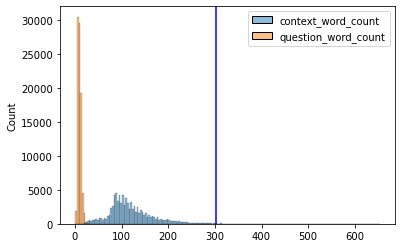

In [59]:
import seaborn as sns
sentence_lengths = pd.DataFrame(
    dataset[['context', 'question']].applymap(str.split).applymap(len).to_numpy(),
    columns=['context_word_count', 'question_word_count'],
)
p99_context = int(np.quantile(sentence_lengths['context_word_count'], 0.99))
p99_question = int(np.quantile(sentence_lengths['question_word_count'], 0.99))
percentile99 = p99_question + p99_context

ax = sns.histplot(sentence_lengths)
ax.axvline(x=percentile99, color='b')
print(f"99% percentile of question + context word count: {percentile99}")
# Note: after tokenization the numbers may differ but not dramatically

### 1.3. Tokenization

In [60]:
# Tokenize the context and questions
tokenizer: PreTrainedTokenizerFast = AutoTokenizer.from_pretrained(HF_MODEL_NAME)
tok = []
log_answers_not_found = 0

for _, row in tqdm(dataset.iterrows(), total=dataset.shape[0]):
    # Standard tokenizer
    t = tokenizer(
        row['question'],
        row['context'],
        max_length=512,
        truncation='only_second',
        padding='max_length',
        return_offsets_mapping=True,
    )

    offset_mapping = np.array(t['offset_mapping'])
    token_type_ids = np.array(t['token_type_ids'])

    # Get where the answer is located, by looking at tokens that satisfy:
    #  - they start after the answer
    #  - they end before the answer
    #  - they are part of the context
    answer_context = (
            (offset_mapping[:, 0] >= row['answer_start']) *
            (offset_mapping[:, 1] <= row['answer_end']) *
            token_type_ids.astype(bool)
    )

    # Note: for now truncation is not handled
    # Debug printing
    # print(row['answer_text'])
    # print(tokenizer.decode(np.array(t['input_ids'])[answer_context]))
    # print(answer_context)

    # Get the first and last index of the answer context
    answer_tok_idx = np.argwhere(answer_context).ravel()
    isp = iep = 0
    if answer_tok_idx.size == 0:
        log_answers_not_found += 1
    else:
        isp = answer_tok_idx[0]
        iep = answer_tok_idx[-1]
        assert isp <= iep

    tok.append({
        'input_ids': torch.tensor(t['input_ids']),
        'token_type_ids': torch.tensor(token_type_ids),
        'attention_mask': torch.tensor(t['attention_mask']),
        'start_positions': torch.tensor(isp),
        'end_positions': torch.tensor(iep),
        'offset_mapping': offset_mapping,
    })

print(f"Answers not found due to truncation: {log_answers_not_found}")

  0%|          | 0/87599 [00:00<?, ?it/s]

Answers not found due to truncation: 171


In [61]:
tokenized_dataset = pd.concat((dataset, pd.DataFrame(tok)), axis=1)
tokenized_dataset.head()

,id,title,context,question,answer_text,answer_start,answer_end,input_ids,token_type_ids,attention_mask,start_positions,end_positions,offset_mapping
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,Saint Bernadette Soubirous,515,541,"[tensor(101), tensor(2000), tensor(3183), tens...","[tensor(0, dtype=torch.int32), tensor(0, dtype...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",tensor(130),tensor(137),"[[0, 0], [0, 2], [3, 7], [8, 11], [12, 15], [1..."
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,a copper statue of Christ,188,213,"[tensor(101), tensor(2054), tensor(2003), tens...","[tensor(0, dtype=torch.int32), tensor(0, dtype...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",tensor(52),tensor(56),"[[0, 0], [0, 4], [5, 7], [8, 10], [11, 16], [1..."
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,the Main Building,279,296,"[tensor(101), tensor(1996), tensor(13546), ten...","[tensor(0, dtype=torch.int32), tensor(0, dtype...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",tensor(81),tensor(83),"[[0, 0], [0, 3], [4, 12], [13, 15], [16, 19], ..."
3,5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,a Marian place of prayer and reflection,381,420,"[tensor(101), tensor(2054), tensor(2003), tens...","[tensor(0, dtype=torch.int32), tensor(0, dtype...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",tensor(95),tensor(101),"[[0, 0], [0, 4], [5, 7], [8, 11], [12, 14], [1..."
4,5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,a golden statue of the Virgin Mary,92,126,"[tensor(101), tensor(2054), tensor(7719), tens...","[tensor(0, dtype=torch.int32), tensor(0, dtype...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",tensor(33),tensor(39),"[[0, 0], [0, 4], [5, 9], [10, 12], [13, 16], [..."


In [62]:
# Test how the questions+context are tokenized and decoded
q = tokenized_dataset.iloc[0]
s = q['question'] + q['context']
t = q['input_ids']
print(s)
print()
print(tokenizer.decode(t))

To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.

[CLS] to whom did the virgin mary allegedly appear in 1858 in lourdes france? [SEP] architecturally, the school has a catholic character. atop the main building's gold dome is a golden statue of the virgin mary. immediately in front

### 1.4. Train-Val split

In [63]:
# Get the questions' titles and shuffle them
titles = tokenized_dataset['title'].unique()
shuffled_titles = pd.Series(titles).sample(frac=1, random_state=RS)

# Get the Question Indices grouped by title
qi_by_titles = tokenized_dataset.groupby(['title']).indices
training_indices = []
min_train_len = int(len(tokenized_dataset) * TRAIN_FRACTION)

# Add questions until enough are present
for title in shuffled_titles:
    training_indices += qi_by_titles[title].tolist()
    if len(training_indices) >= min_train_len:
        break

# Create the datasets using the indices
ds_train = tokenized_dataset.iloc[training_indices]
ds_val = tokenized_dataset.drop(ds_train.index)

print(f"Training samples: {len(ds_train)}")
print(f"Validation samples: {len(ds_val)}")
print(f"Actual fraction: {len(ds_train) / len(tokenized_dataset):.4f}")

Training samples: 78964
Validation samples: 8635
Actual fraction: 0.9014


### 1.5. Converting the data for PyTorch

In [64]:
class QADataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        return {
            'input_ids': item['input_ids'],
            'token_type_ids': item['token_type_ids'],
            'attention_mask': item['attention_mask'],
            'start_positions': item['start_positions'],
            'end_positions': item['end_positions']
        }

    @staticmethod
    def load(ds, shuffle,batch_size=BATCH_SIZE):
        return DataLoader(QADataset(ds), batch_size=batch_size, shuffle=shuffle, pin_memory=True)

In [65]:
train_loader = QADataset.load(ds_train, shuffle=True)
val_loader = QADataset.load(ds_val, shuffle=False)

## 2. Training the model

### 2.1. Loading the model & Custom model definition

In [66]:
# https://github.com/huggingface/transformers/blob/v4.16.2/src/transformers/models/bert/modeling_bert.py#L1792
class CustomBertForQuestionAnswering(BertForQuestionAnswering):
    def __init__(self, config):
        super(BertForQuestionAnswering, self).__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config, add_pooling_layer=False)
        self.qa_outputs = nn.Sequential(
            nn.Dropout(DROPOUT),
            nn.Linear(config.hidden_size, config.num_labels),
        )


In [67]:
if USE_CUSTOM_MODEL:
    model: BertForQuestionAnswering = CustomBertForQuestionAnswering.from_pretrained(HF_MODEL_NAME)
    print("Using custom model")
else:
    model: BertForQuestionAnswering = BertForQuestionAnswering.from_pretrained(HF_MODEL_NAME)
    print("Using Huggingface Question Answering model")

Using Huggingface Question Answering model


In [68]:
torchinfo.summary(model, input_data=next(iter(QADataset.load(ds_val, shuffle=False))))

Layer (type:depth-idx)                                  Output Shape              Param #
BertForQuestionAnswering                                --                        --
├─BertModel: 1                                          --                        --
│    └─BertEncoder: 2                                   --                        --
│    │    └─ModuleList: 3-1                             --                        25,219,072
├─BertModel: 1-1                                        [16, 512, 512]            --
│    └─BertEmbeddings: 2-1                              [16, 512, 512]            --
│    │    └─Embedding: 3-2                              [16, 512, 512]            15,627,264
│    │    └─Embedding: 3-3                              [16, 512, 512]            1,024
│    │    └─Embedding: 3-4                              [1, 512, 512]             262,144
│    │    └─LayerNorm: 3-5                              [16, 512, 512]            1,024
│    │    └─Dropout: 3-6         

### 2.2. Metrics

In [69]:
def calc_f1(answer_text, answer_text_pred):
    f1s = []
    for text, pred in zip(answer_text, answer_text_pred):
        f1s.append(evaluate.compute_f1(text, pred))
    return pd.Series(f1s, name='f1')

def calc_em_str(answer_text, answer_text_pred):
    # Use string comparison
    return (answer_text == answer_text_pred).astype(int).rename('em')

def calc_em_tensor(answer_start, answer_end, answer_start_pred, answer_end_pred):
    # Use TOKEN index comparison
    return torch.logical_and(
        answer_start == answer_start_pred,
        answer_end == answer_end_pred,
    ).float()

### 2.3. Validation / Evaluation function

In [70]:
def evaluate_model(model, loader: DataLoader, check_bounds, return_frame=False, display_bar=False):
    _loader = tqdm(loader) if display_bar else loader

    # Store the answers' TOK indices
    answer_start_tok= []
    answer_end_tok= []

    # Get outputs from the model
    model.to(device)
    model.eval()
    with torch.no_grad():
        for batch in _loader:
            args = dict(
                input_ids=batch['input_ids'].to(device, non_blocking=True),
                attention_mask=batch['attention_mask'].to(device, non_blocking=True),
                token_type_ids=batch['token_type_ids'].to(device, non_blocking=True),
            )
            outputs = model(**args)

            # Get the answers' TOK indices, masked by the Token-Type-Ids (1s only iff context)
            mask = ((args['token_type_ids'] - 1) * torch.inf).nan_to_num(0)  # -inf if tok!=context; 0 otherwise
            start_logits = outputs['start_logits'] + mask
            end_logits = outputs['end_logits'] + mask
            start_tok_indices = torch.argmax(start_logits, dim=1).tolist()
            end_tok_indices = torch.argmax(end_logits, dim=1).tolist()

            if not check_bounds:
                answer_start_tok += start_tok_indices
                answer_end_tok += end_tok_indices
                continue

            for k in range(len(start_tok_indices)):
                sti, eti = start_tok_indices[k], end_tok_indices[k]
                # Check if start token index <= end token index (VALID)
                if sti <= eti:
                    answer_start_tok.append(sti)
                    answer_end_tok.append(eti)
                    continue

                # Otherwise, pick (start, end) = (i, j)
                # such that i <= j and start_logits[i] + end_logits[j] is the highest
                # among all the (i, j) couples
                valid_logits = {}
                candidate_sti = start_logits[k].argsort(descending=True)[:20]
                candidate_eti = end_logits[k].argsort(descending=True)[:20]

                for i in candidate_sti:
                    for j in candidate_eti:
                        if i <= j:
                            valid_logits[(i, j)] = (start_logits[k, i] + end_logits[k, j]).item()

                # Get the argmax of the valid logits sum and append the results
                if len(valid_logits) > 0:
                    sti, eti = max(valid_logits, key=valid_logits.get)
                answer_start_tok.append(sti)
                answer_end_tok.append(eti)

    # Convert the TOK indices into TEXT using the context
    df = loader.dataset.df.reset_index()
    answer_text_pred = []
    for idx, row in df.iterrows():
        om = row['offset_mapping']
        tst, ten = answer_start_tok[idx], answer_end_tok[idx]  # Tok start, tok end
        cst, cen = om[tst, 0], om[ten, 1]  # Char start, Char end
        answer_text_pred.append(row['context'][cst:cen])
    answer_text_pred = pd.Series(answer_text_pred)

    # Compute the metrics
    f1s = calc_f1(df['answer_text'], answer_text_pred)
    ems = calc_em_str(df['answer_text'], answer_text_pred)

    out = {'f1_mean': sum(f1s)/len(f1s), 'em_mean': sum(ems)/len(ems)}
    if return_frame:
        out['dataframe'] = pd.concat([df, pd.DataFrame({'answer_text_pred': answer_text_pred,
                                                        'f1': f1s,
                                                        'em': ems})], axis=1)

    return out

### 2.4. Wandb Integration & Model save-load functions

In [71]:
Path(MODELS_FOLDER).mkdir(parents=True, exist_ok=True)
model_save_name = MODEL_SAVE_NAME if MODEL_SAVE_NAME is not None else HF_MODEL_NAME.split('/')[-1]
save_filepath = f"{MODELS_FOLDER}/{model_save_name}_{datetime.today().strftime('%m%d')}.pt"

def save_model(model, filepath=save_filepath):
    torch.save(model.state_dict(), filepath)
    # print(f'Model saved in {filepath}')

def load_model(model, filepath=save_filepath):
    model.load_state_dict(torch.load(filepath))
    print(f'Loaded model at {filepath}')

In [72]:
%env WANDB_SILENT=True

env: WANDB_SILENT=True


In [ ]:
wandb_params = dict(
    project="NLP-Question-Answering",
    entity="frantoman",
    reinit=True,
    group=HF_MODEL_NAME,
    name=model_save_name,
    config=dict(
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        learning_rate_base=BASE_LEARNING_RATE,
        learning_rate_max=MAX_LEARNING_RATE,
        optimizer='adam',
        weight_decay=WEIGHT_DECAY,
        model_name=HF_MODEL_NAME,
        dropout=DROPOUT,
    )
)

run = None
if USE_WANDB:
    run = wandb.init(**wandb_params)
    print(f"Logging run {run.name} at {run.url}")

### 2.5. Training loop

In [21]:
# Freeze the bert embedding layers
for param in model.bert.embeddings.parameters():
    param.requires_grad = False

In [ ]:
# Initialize training stuff
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
opt = torch.optim.AdamW(model.parameters(), lr=BASE_LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CyclicLR(
    opt,
    base_lr=BASE_LEARNING_RATE,
    max_lr=MAX_LEARNING_RATE,
    mode='triangular2',
    step_size_up=len(train_loader) // 2,
    cycle_momentum=False,
)
scaler = torch.cuda.amp.GradScaler()

torch.cuda.empty_cache()
model.train()
best_score = 0  # Used for determining when the model performance over the epochs is degrading

# Iterate through the epochs
for epoch in range(1, EPOCHS + 1):
    # Epoch's history
    ep_loss = []
    ep_em = []

    train_iter = tqdm(train_loader, desc=f'Epoch {epoch}', leave=True)

    # Training
    for train_batch in train_iter:
        with torch.cuda.amp.autocast():
            # Extract the model arguments from the batch, and do a forward-pass
            args = dict(
                input_ids=train_batch['input_ids'].to(device, non_blocking=True),
                attention_mask=train_batch['attention_mask'].to(device, non_blocking=True),
                start_positions=train_batch['start_positions'].to(device, non_blocking=True),
                end_positions=train_batch['end_positions'].to(device, non_blocking=True),
                token_type_ids=train_batch['token_type_ids'].to(device, non_blocking=True),
            )
            outputs = model(**args)

        # Get the starting and end token indices
        start_pred = torch.argmax(outputs['start_logits'], dim=1)
        end_pred = torch.argmax(outputs['end_logits'], dim=1)

        # Log the Loss and Exact Matches for the batch
        loss = outputs['loss']
        em = calc_em_tensor(args['start_positions'], args['end_positions'], start_pred, end_pred)
        em_mean = em.mean().item()
        ep_loss.append(loss.item())
        ep_em.append(em_mean)

        # Update the progress bar
        train_iter.set_postfix(loss=sum(ep_loss[-50:]) / len(ep_loss[-50:]),
                               em=sum(ep_em[-50:]) / len(ep_em[-50:]))

        # Backwards-pass
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        opt.zero_grad(set_to_none=True)
        scheduler.step()

    # Validation & Saving
    val_out = evaluate_model(model, val_loader, check_bounds=CHECK_VAL_BOUNDS)
    f1, em = val_out['f1_mean'], val_out['em_mean']
    try:
        score = (2 * f1 * em) / (f1 + em)  # Harmonic mean
    except ZeroDivisionError:
        score = 0
    if f1 > best_score:
        best_score = score
        save_model(model)

    # End of epoch logging
    train_iter.close()
    if USE_WANDB:
        run.log(dict(
            epoch=epoch,
            em=sum(ep_em) / len(ep_em),
            loss=sum(ep_loss) / len(ep_loss),
            val_em=em,
            val_f1=f1,
            score=score,
        ))

### 2.6. Uploading artifacts to Wandb

In [ ]:
if USE_WANDB:
    # Upload the fine-tuned model
    model_save_artifact = wandb.Artifact('model', type='model')
    model_save_artifact.add_file(save_filepath)
    run.log_artifact(model_save_artifact)

    # Upload some (100) validation outputs of the model
    load_model(model)
    out = evaluate_model(model, QADataset.load(ds_val.iloc[:100], shuffle=False), return_frame=True, check_bounds=True)
    df = out['dataframe'][['question', 'context', 'answer_text', 'answer_text_pred', 'f1', 'em']]
    out_table = wandb.Table(data=df, columns=df.columns)
    result_artifact = wandb.Artifact('validation_output', type='result')
    result_artifact.add(out_table, 'validation_output')
    run.log_artifact(result_artifact)
    run.finish()